In [1]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
import torchvision

from torchvision import datasets
from torchvision import transforms
from torchvision.utils import make_grid

from tqdm import tqdm
#from torchinfo import summary

import numpy as np
import matplotlib.pyplot as plt


In [2]:
print('GPU name:', torch.cuda.get_device_name(), '\n')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

GPU name: NVIDIA A100-PCIE-40GB 



# Load MNIST dataset


In [3]:
transform = transforms.Compose([transforms.Resize((32, 32)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5,), std=(0.5,))])

training_dataset = datasets.MNIST(root='./data_src', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data_src', train=False, download=True, transform=transform)

# Define dataloaders


In [4]:

training_dataloader = DataLoader(training_dataset, batch_size=32, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=True)

# Define Linear_Variance_Scheduler


In [5]:
class Linear_Variance_Scheduler:
    def __init__(self, time_steps, beta_start, beta_end, device='cuda'):
        self.time_steps = time_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.device = device

        self.betas = torch.linspace(self.beta_start, self.beta_end, self.time_steps).to(self.device)
        self.alphas = 1 - self.betas
        self.alpha_bar = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alpha_bar = torch.sqrt(self.alpha_bar)
        self.sqrt_one_minus_alpha_bar = torch.sqrt(1 - self.alpha_bar)

    def diffusion_process(self, x, noise, t):
        t = torch.clamp(t, max=self.time_steps - 1)  # Ensure t is within bounds
        sqrt_alpha_bar = self.sqrt_alpha_bar[t][:, None, None, None]
        sqrt_one_minus_alpha_bar = self.sqrt_one_minus_alpha_bar[t][:, None, None, None]
        return sqrt_alpha_bar * x + sqrt_one_minus_alpha_bar * noise

    def ddpm_sampling(self, model, num_samples, channels, img_size):
        model.eval()
        with torch.inference_mode():
            x = torch.randn((num_samples, channels, img_size, img_size)).to(self.device)
            collect = []
            for i in tqdm(reversed(range(self.time_steps))):
                t = torch.full((num_samples,), i, dtype=torch.long, device=self.device)
                pred_noise = model(x, t)
                alphas = self.alphas[t][:, None, None, None]
                alpha_bar = self.alpha_bar[t][:, None, None, None]
                betas = self.betas[t][:, None, None, None]
                if i > 0:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = (1 / torch.sqrt(alphas)) * (x - ((1 - alphas) / torch.sqrt(1 - alpha_bar)) * pred_noise) + torch.sqrt(betas) * noise
                if (i+1) % 100 == 0 or i == 0:
                    collect.append(x)
            return x, collect


In [6]:
import math

class Cosine_Variance_Scheduler:
    def __init__(self, time_steps, s=0.008, device='cuda'):
        self.time_steps = time_steps
        self.s = s
        self.device = device

        steps = torch.arange(self.time_steps + 1, dtype=torch.float64)
        t = steps / self.time_steps

        # Compute alpha_bar using cosine schedule
        f = lambda t: torch.cos((t + self.s) / (1 + self.s) * math.pi / 2) ** 2
        alphas_cumprod = f(t) / f(torch.tensor(0.0, dtype=torch.float64))

        # Shift by 1 to align with time steps
        self.alpha_bar = alphas_cumprod[1:].to(self.device).float()
        self.alphas = self.alpha_bar / torch.cat([torch.tensor([1.0], device=self.device), self.alpha_bar[:-1]])
        self.betas = 1 - self.alphas

        self.sqrt_alpha_bar = torch.sqrt(self.alpha_bar)
        self.sqrt_one_minus_alpha_bar = torch.sqrt(1 - self.alpha_bar)

    def diffusion_process(self, x, noise, t):
        t = torch.clamp(t, max=self.time_steps - 1)
        sqrt_alpha_bar = self.sqrt_alpha_bar[t][:, None, None, None]
        sqrt_one_minus_alpha_bar = self.sqrt_one_minus_alpha_bar[t][:, None, None, None]
        return sqrt_alpha_bar * x + sqrt_one_minus_alpha_bar * noise

    def ddpm_sampling(self, model, num_samples, channels, img_size):
        model.eval()
        with torch.inference_mode():
            x = torch.randn((num_samples, channels, img_size, img_size)).to(self.device)
            collect = []
            for i in tqdm(reversed(range(self.time_steps))):
                t = torch.full((num_samples,), i, dtype=torch.long, device=self.device)
                pred_noise = model(x, t)
                alphas = self.alphas[t][:, None, None, None]
                alpha_bar = self.alpha_bar[t][:, None, None, None]
                betas = self.betas[t][:, None, None, None]
                if i > 0:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = (1 / torch.sqrt(alphas)) * (x - ((1 - alphas) / torch.sqrt(1 - alpha_bar)) * pred_noise) + torch.sqrt(betas) * noise
                if (i+1) % 100 == 0 or i == 0:
                    collect.append(x)
            return x, collect


In [7]:
class Sigmoid_Variance_Scheduler:
    def __init__(self, time_steps, k=10, t_0=0.5, device='cuda'):
        self.time_steps = time_steps
        self.device = device
        self.k = k
        self.t_0 = t_0

        steps = torch.linspace(0, 1, self.time_steps + 1, dtype=torch.float64)
        t = steps

        # Compute alpha_bar using sigmoid function
        sigmoid = lambda t: 1 / (1 + torch.exp(-self.k * (t - self.t_0)))
        alpha_bar_t = 1 - sigmoid(t)

        # Normalize alpha_bar_t to ensure it starts at 1 and ends near 0
        alpha_bar_t = (alpha_bar_t - alpha_bar_t.min()) / (alpha_bar_t.max() - alpha_bar_t.min())
        alpha_bar_t = alpha_bar_t * 0.9999 + 0.0001  # Avoid exactly 0 or 1

        self.alpha_bar = alpha_bar_t[1:].to(self.device).float()
        self.alphas = self.alpha_bar / torch.cat([torch.tensor([1.0], device=self.device), self.alpha_bar[:-1]])
        self.betas = 1 - self.alphas

        self.sqrt_alpha_bar = torch.sqrt(self.alpha_bar)
        self.sqrt_one_minus_alpha_bar = torch.sqrt(1 - self.alpha_bar)

    def diffusion_process(self, x, noise, t):
        t = torch.clamp(t, max=self.time_steps - 1)
        sqrt_alpha_bar = self.sqrt_alpha_bar[t][:, None, None, None]
        sqrt_one_minus_alpha_bar = self.sqrt_one_minus_alpha_bar[t][:, None, None, None]
        return sqrt_alpha_bar * x + sqrt_one_minus_alpha_bar * noise

    def ddpm_sampling(self, model, num_samples, channels, img_size):
        model.eval()
        with torch.inference_mode():
            x = torch.randn((num_samples, channels, img_size, img_size)).to(self.device)
            collect = []
            for i in tqdm(reversed(range(self.time_steps))):
                t = torch.full((num_samples,), i, dtype=torch.long, device=self.device)
                pred_noise = model(x, t)
                alphas = self.alphas[t][:, None, None, None]
                alpha_bar = self.alpha_bar[t][:, None, None, None]
                betas = self.betas[t][:, None, None, None]
                if i > 0:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = (1 / torch.sqrt(alphas)) * (x - ((1 - alphas) / torch.sqrt(1 - alpha_bar)) * pred_noise) + torch.sqrt(betas) * noise
                if (i+1) % 100 == 0 or i == 0:
                    collect.append(x)
            return x, collect


In [8]:
# Define time steps at which to visualize the image
t_step = torch.linspace(start=0, end=999, steps=11).long()

# Get a single image from the training dataset
get_img = training_dataset[0][0]

# Repeat the image to match the number of time steps
get_img_stack = torch.stack([get_img] * len(t_step))

# Generate random noise for each time step
get_noise_stack = torch.randn_like(get_img_stack)

In [9]:
linear_scheduler = Linear_Variance_Scheduler(time_steps=1000, beta_start=0.0001, beta_end=0.02, device='cpu')
linear_noisy_imgs = linear_scheduler.diffusion_process(get_img_stack, get_noise_stack, t_step)

cosine_scheduler = Cosine_Variance_Scheduler(time_steps=1000, device='cpu')
cosine_noisy_imgs = cosine_scheduler.diffusion_process(get_img_stack, get_noise_stack, t_step)

sigmoid_scheduler = Sigmoid_Variance_Scheduler(time_steps=1000, k=10, t_0=0.5, device='cpu')
sigmoid_noisy_imgs = sigmoid_scheduler.diffusion_process(get_img_stack, get_noise_stack, t_step)


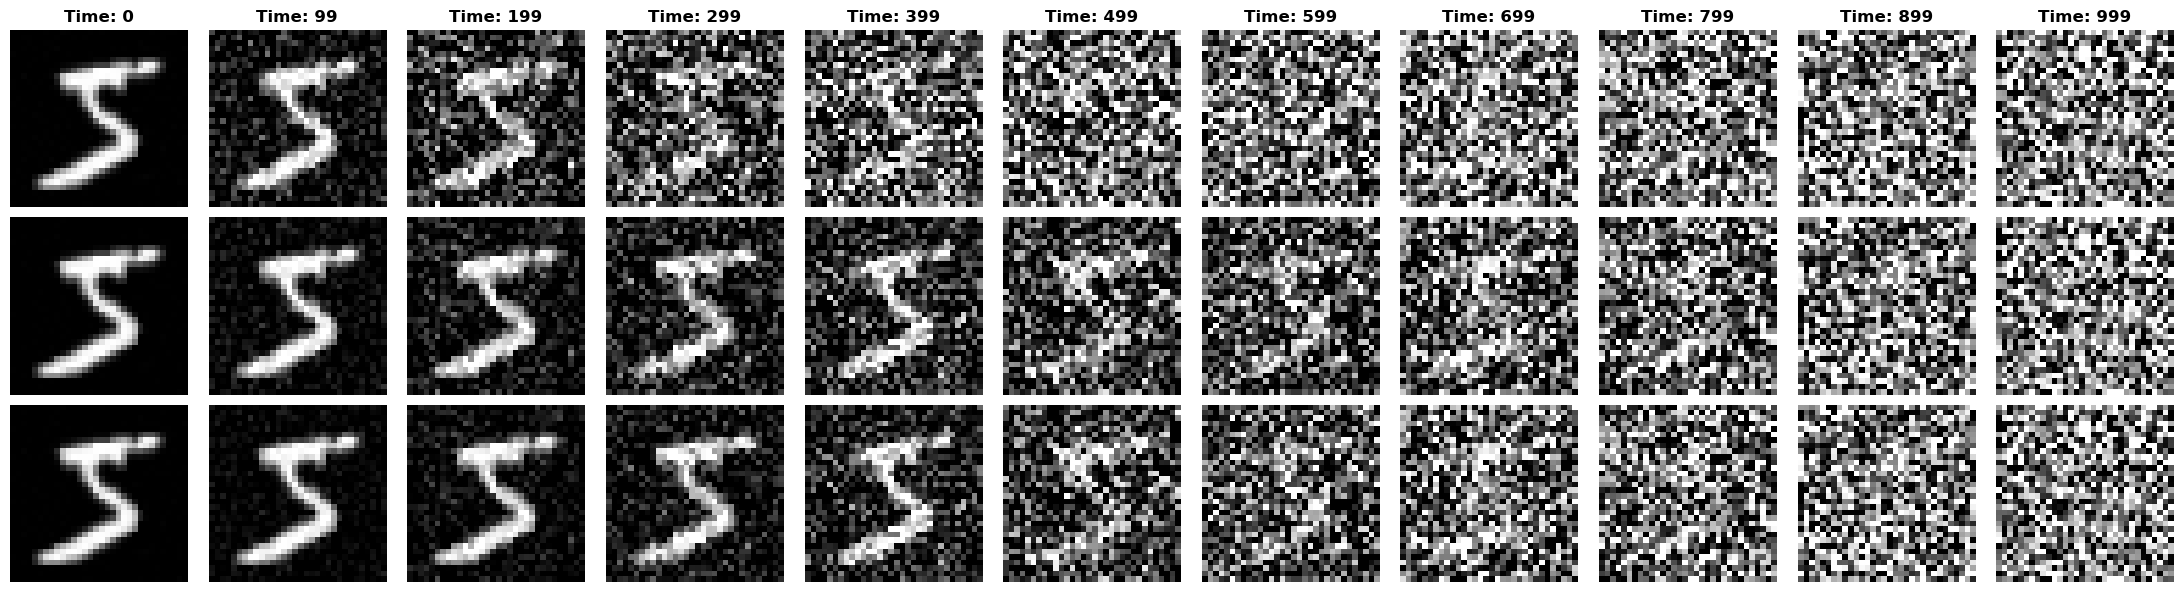

In [10]:
fig, axes = plt.subplots(3, len(t_step), figsize=(22, 6))

schedulers = ['Linear', 'Cosine', 'Sigmoid']
noisy_imgs_list = [linear_noisy_imgs, cosine_noisy_imgs, sigmoid_noisy_imgs]

for row_idx, (scheduler_name, noisy_imgs) in enumerate(zip(schedulers, noisy_imgs_list)):
    for col_idx in range(len(t_step)):
        img = noisy_imgs[col_idx].permute(1, 2, 0).squeeze().cpu().numpy()
        img = (img * 0.5) + 0.5  # Unnormalize if necessary
        img = np.clip(img, 0, 1)
        axes[row_idx, col_idx].imshow(img, cmap='gray')
        if row_idx == 0:
            axes[row_idx, col_idx].set_title(f'Time: {t_step[col_idx].item()}', fontweight='bold')
        if col_idx == 0:
            axes[row_idx, col_idx].set_ylabel(scheduler_name, rotation=90, size='large', fontweight='bold')
        axes[row_idx, col_idx].axis('off')

plt.tight_layout()
plt.show()


### Play with forward parameters

#### U-net Architecture:
- Resblock
- SelfAttentionBlock
- Downblock
- Upblock

# Create ResBlock

In [11]:
class ResBlock(nn.Module):
    def __init__(self, inp_ch, out_ch, mid_ch=None, residual=False):
        super(ResBlock, self).__init__()
        
        self.residual = residual
        if not mid_ch:
            mid_ch = out_ch
        self.resnet_conv = nn.Sequential()
        self.resnet_conv.add_module('conv1', nn.Conv2d(in_channels=inp_ch, out_channels=mid_ch, kernel_size=3, stride=1,
                                                       padding=1))
        self.resnet_conv.add_module('gnor1', nn.GroupNorm(num_groups=8, num_channels=mid_ch))
        self.resnet_conv.add_module('silu1', nn.SiLU())
        self.resnet_conv.add_module('conv2', nn.Conv2d(in_channels=mid_ch, out_channels=out_ch, kernel_size=3, stride=1,
                                                       padding=1))
        self.resnet_conv.add_module('gnor2', nn.GroupNorm(num_groups=8, num_channels=out_ch))
        
    def forward(self, x):
        if self.residual:
            return x + self.resnet_conv(x)
        else:
            return self.resnet_conv(x)

# Create SelfAttentionBlock

In [12]:
class SelfAttentionBlock(nn.Module):
    def __init__(self, channels):
        super(SelfAttentionBlock, self).__init__()
        
        self.attn_norm = nn.GroupNorm(num_groups=8, num_channels=channels)
        self.mha = nn.MultiheadAttention(embed_dim=channels, num_heads=4, batch_first=True)
        
    def forward(self, x):
        b, c, h, w = x.shape
        inp_attn = x.reshape(b, c, h*w)
        inp_attn = self.attn_norm(inp_attn)
        inp_attn = inp_attn.transpose(1, 2)
        out_attn, _ = self.mha(inp_attn, inp_attn, inp_attn)
        out_attn = out_attn.transpose(1, 2).reshape(b, c, h, w)
        return x + out_attn

# Create DownBlock

In [13]:
class DownBlock(nn.Module):
    def __init__(self, inp_ch, out_ch, t_emb_dim=256):
        super(DownBlock, self).__init__()
        
        self.down = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            ResBlock(inp_ch=inp_ch, out_ch=inp_ch, residual=True),
            ResBlock(inp_ch=inp_ch, out_ch=out_ch)
        )
        
        self.t_emb_layers = nn.Sequential()
        self.t_emb_layers.add_module('silu1', nn.SiLU())
        self.t_emb_layers.add_module('linr1', nn.Linear(in_features=t_emb_dim, out_features=out_ch))
        
    def forward(self, x, t):
        x = self.down(x)
        t_emb = self.t_emb_layers(t)[:, :, None, None].repeat(1, 1, x.shape[2], x.shape[3])
        return x + t_emb

# Create UpBlock

In [14]:
class UpBlock(nn.Module):
    def __init__(self, inp_ch, out_ch, t_emb_dim=256):
        super(UpBlock, self).__init__()
        
        self.upsamp = nn.UpsamplingBilinear2d(scale_factor=2)
        self.up = nn.Sequential(
            ResBlock(inp_ch=inp_ch, out_ch=inp_ch, residual=True),
            ResBlock(inp_ch=inp_ch, out_ch=out_ch, mid_ch=inp_ch//2)
        )
        
        self.t_emb_layers = nn.Sequential()
        self.t_emb_layers.add_module('silu1', nn.SiLU())
        self.t_emb_layers.add_module('linr1', nn.Linear(in_features=t_emb_dim, out_features=out_ch))
        
    def forward(self, x, skip, t):
        x = self.upsamp(x)
        x = torch.cat([skip, x], dim=1)
        x = self.up(x)
        t_emb = self.t_emb_layers(t)[:, :, None, None].repeat(1, 1, x.shape[2], x.shape[3])
        return x + t_emb

# Create UNet

In [15]:
class UNet(nn.Module):
    def __init__(self, t_emb_dim, device='cuda'):
        super(UNet, self).__init__()
        
        self.device = device
        self.t_emb_dim = t_emb_dim
        
        self.inp = ResBlock(inp_ch=1, out_ch=64)
        self.down1 = DownBlock(inp_ch=64, out_ch=128)
        self.sa1 = SelfAttentionBlock(channels=128)
        self.down2 = DownBlock(inp_ch=128, out_ch=256)
        self.sa2 = SelfAttentionBlock(channels=256)
        self.down3 = DownBlock(inp_ch=256, out_ch=256)
        self.sa3 = SelfAttentionBlock(channels=256)
        
        self.lat1 = ResBlock(inp_ch=256, out_ch=512)
        self.lat2 = ResBlock(inp_ch=512, out_ch=512)
        self.lat3 = ResBlock(inp_ch=512, out_ch=256)
        
        self.up1 = UpBlock(inp_ch=512, out_ch=128)
        self.sa4 = SelfAttentionBlock(channels=128)
        self.up2 = UpBlock(inp_ch=256, out_ch=64)
        self.sa5 = SelfAttentionBlock(channels=64)
        self.up3 = UpBlock(inp_ch=128, out_ch=64)
        self.sa6 = SelfAttentionBlock(channels=64)
        
        self.out = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1)
        
    def position_embeddings(self, t, channels):
        i = 1 / (10000 ** (torch.arange(start=0, end=channels, step=2, device=self.device) / channels))
        pos_emb_sin = torch.sin(t.repeat(1, channels//2) * i)
        pos_emb_cos = torch.cos(t.repeat(1, channels//2) * i)
        pos_emb = torch.cat([pos_emb_sin, pos_emb_cos], dim=-1)
        return pos_emb
    
    def forward(self, x, t):
        t = t.unsqueeze(1).float()
        t = self.position_embeddings(t, self.t_emb_dim)
        
        x1 = self.inp(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)
        
        x4 = self.lat1(x4)
        x4 = self.lat2(x4)
        x4 = self.lat3(x4)
        
        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.out(x)
        return output

In [16]:
from torchinfo import summary

summary(UNet(t_emb_dim=256), input_size=[(64, 1, 32, 32), (64,)])


Layer (type:depth-idx)                        Output Shape              Param #
UNet                                          [64, 1, 32, 32]           --
├─ResBlock: 1-1                               [64, 64, 32, 32]          --
│    └─Sequential: 2-1                        [64, 64, 32, 32]          --
│    │    └─Conv2d: 3-1                       [64, 64, 32, 32]          640
│    │    └─GroupNorm: 3-2                    [64, 64, 32, 32]          128
│    │    └─SiLU: 3-3                         [64, 64, 32, 32]          --
│    │    └─Conv2d: 3-4                       [64, 64, 32, 32]          36,928
│    │    └─GroupNorm: 3-5                    [64, 64, 32, 32]          128
├─DownBlock: 1-2                              [64, 128, 16, 16]         --
│    └─Sequential: 2-2                        [64, 128, 16, 16]         --
│    │    └─MaxPool2d: 3-6                    [64, 64, 16, 16]          --
│    │    └─ResBlock: 3-7                     [64, 64, 16, 16]          74,112
│    │   

# SET-UP

In [17]:
ddpm_cosine = Cosine_Variance_Scheduler(time_steps=1000)
model = UNet(t_emb_dim=256).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


# TRAINING

In [18]:
torch.manual_seed(1111)
torch.cuda.manual_seed(1111)
torch.cuda.manual_seed_all(1111)
np.random.seed(1111)

n_epochs = 1
training_loss, test_loss = [], []

for epoch in range(n_epochs):
    training_losses, test_losses = [], []
    
    for data, _ in tqdm(training_dataloader):
        model.train()
        data = data.to(device)
        t = torch.randint(low=0, high=1000, size=(data.shape[0],)).to(device)
        noise = torch.randn_like(data)
        xt = ddpm_cosine.diffusion_process(x=data, noise=noise, t=t)
        pred_noise = model(xt, t)
        trng_batch_loss = criterion(noise, pred_noise)
        optimizer.zero_grad()
        trng_batch_loss.backward()
        optimizer.step()
        training_losses.append(trng_batch_loss.item())
    training_per_epoch_loss = np.array(training_losses).mean()
    
    with torch.inference_mode():
        for data, _ in tqdm(test_dataloader):
            model.eval()
            data = data.to(device)
            t = torch.randint(low=0, high=1000, size=(data.shape[0],)).to(device)
            noise = torch.randn_like(data)
            xt = ddpm_cosine.diffusion_process(x=data, noise=noise, t=t)
            pred_noise = model(xt, t)
            tst_batch_loss = criterion(noise, pred_noise)
            test_losses.append(tst_batch_loss.item())
        test_per_epoch_loss = np.array(test_losses).mean()

    training_loss.append(training_per_epoch_loss)
    test_loss.append(test_per_epoch_loss)
    
    print(f'Epoch: {epoch+1}/{n_epochs}\t| Training loss: {training_per_epoch_loss:.4f} |   ', end='')
    print(f'Test loss: {test_per_epoch_loss:.4f}')
    


  0%|          | 0/1875 [00:00<?, ?it/s]

100%|██████████| 312/312 [00:06<00:00, 47.42it/s]

Epoch: 1/1	| Training loss: 0.0735 |   Test loss: 0.0451


In [19]:
ddpm_linear = Linear_Variance_Scheduler(time_steps=1000, beta_start=0.0001, beta_end=0.02)
model_linear = UNet(t_emb_dim=256).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_linear.parameters(), lr=0.0001)

In [20]:
torch.manual_seed(1111)
torch.cuda.manual_seed(1111)
torch.cuda.manual_seed_all(1111)
np.random.seed(1111)

n_epochs = 1
training_loss, test_loss = [], []

for epoch in range(n_epochs):
    training_losses, test_losses = [], []
    
    for data, _ in tqdm(training_dataloader):
        model_linear.train()
        data = data.to(device)
        t = torch.randint(low=0, high=1000, size=(data.shape[0],)).to(device)
        noise = torch.randn_like(data)
        xt = ddpm_linear.diffusion_process(x=data, noise=noise, t=t)
        pred_noise = model_linear(xt, t)
        trng_batch_loss = criterion(noise, pred_noise)
        optimizer.zero_grad()
        trng_batch_loss.backward()
        optimizer.step()
        training_losses.append(trng_batch_loss.item())
    training_per_epoch_loss = np.array(training_losses).mean()
    
    with torch.inference_mode():
        for data, _ in tqdm(test_dataloader):
            model_linear.eval()
            data = data.to(device)
            t = torch.randint(low=0, high=1000, size=(data.shape[0],)).to(device)
            noise = torch.randn_like(data)
            xt = ddpm_linear.diffusion_process(x=data, noise=noise, t=t)
            pred_noise = model_linear(xt, t)
            tst_batch_loss = criterion(noise, pred_noise)
            test_losses.append(tst_batch_loss.item())
        test_per_epoch_loss = np.array(test_losses).mean()

    training_loss.append(training_per_epoch_loss)
    test_loss.append(test_per_epoch_loss)
    
    print(f'Epoch: {epoch+1}/{n_epochs}\t| Training loss: {training_per_epoch_loss:.4f} |   ', end='')
    print(f'Test loss: {test_per_epoch_loss:.4f}')
    


  0%|          | 0/1875 [00:00<?, ?it/s]

100%|██████████| 312/312 [00:06<00:00, 47.89it/s]

Epoch: 1/1	| Training loss: 0.0445 |   Test loss: 0.0273


In [21]:
ddpm_sigmoid = Sigmoid_Variance_Scheduler(time_steps=1000, k=10, t_0=0.5, device=device)
model_sigmoid = UNet(t_emb_dim=256).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_sigmoid.parameters(), lr=0.0001)

In [22]:
torch.manual_seed(1111)
torch.cuda.manual_seed(1111)
torch.cuda.manual_seed_all(1111)
np.random.seed(1111)

n_epochs = 1
training_loss, test_loss = [], []

for epoch in range(n_epochs):
    training_losses, test_losses = [], []
    
    for data, _ in tqdm(training_dataloader):
        model_sigmoid.train()
        data = data.to(device)
        t = torch.randint(low=0, high=1000, size=(data.shape[0],)).to(device)
        noise = torch.randn_like(data)
        xt = ddpm_sigmoid.diffusion_process(x=data, noise=noise, t=t)
        pred_noise = model_sigmoid(xt, t)
        trng_batch_loss = criterion(noise, pred_noise)
        optimizer.zero_grad()
        trng_batch_loss.backward()
        optimizer.step()
        training_losses.append(trng_batch_loss.item())
    training_per_epoch_loss = np.array(training_losses).mean()
    
    with torch.inference_mode():
        for data, _ in tqdm(test_dataloader):
            model_sigmoid.eval()
            data = data.to(device)
            t = torch.randint(low=0, high=1000, size=(data.shape[0],)).to(device)
            noise = torch.randn_like(data)
            xt = ddpm_sigmoid.diffusion_process(x=data, noise=noise, t=t)
            pred_noise = model_sigmoid(xt, t)
            tst_batch_loss = criterion(noise, pred_noise)
            test_losses.append(tst_batch_loss.item())
        test_per_epoch_loss = np.array(test_losses).mean()

    training_loss.append(training_per_epoch_loss)
    test_loss.append(test_per_epoch_loss)
    
    print(f'Epoch: {epoch+1}/{n_epochs}\t| Training loss: {training_per_epoch_loss:.4f} |   ', end='')
    print(f'Test loss: {test_per_epoch_loss:.4f}')
    


100%|██████████| 312/312 [00:06<00:00, 47.29it/s]

Epoch: 1/1	| Training loss: 0.0739 |   Test loss: 0.0480


# Reverse process

In [23]:
sampled_imgs_linear, _ = ddpm_linear.ddpm_sampling(model=model_linear, num_samples=64, channels=1, img_size=32)
sampled_imgs_cosine, _ = ddpm_cosine.ddpm_sampling(model=model, num_samples=64, channels=1, img_size=32)
sampled_imgs_sigmoid, _ = ddpm_sigmoid.ddpm_sampling(model=model_sigmoid, num_samples=64, channels=1, img_size=32)


1000it [00:23, 41.89it/s]
1000it [00:23, 42.67it/s]
1000it [00:23, 42.10it/s]


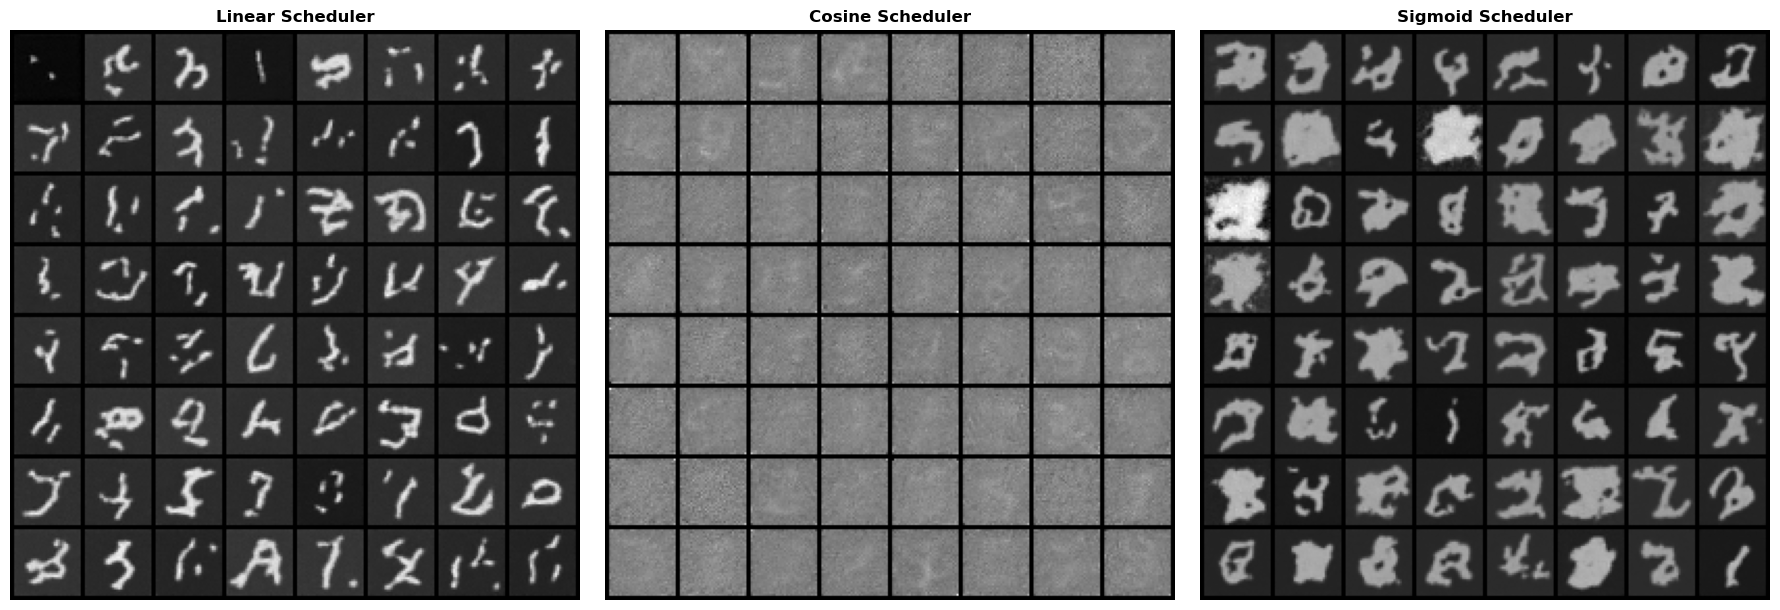

In [24]:
from torchvision.utils import make_grid

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sampled_imgs_list = [sampled_imgs_linear, sampled_imgs_cosine, sampled_imgs_sigmoid]
titles = ['Linear Scheduler', 'Cosine Scheduler', 'Sigmoid Scheduler']

for idx, (imgs, title) in enumerate(zip(sampled_imgs_list, titles)):
    grid = make_grid(imgs.detach().cpu(), nrow=8, normalize=True)
    axes[idx].imshow(grid.permute(1, 2, 0))
    axes[idx].set_title(title, fontweight='bold')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


**TODO**
## EVALUATION